<h1><center>2021 BRFSS Data: Part 4</center></h1>


#### About the data:
- The dataset used in this project is the 2021 BRFSS Data.
- The Behavioral Risk Factor Surveillance System (BRFSS) is a collaborative project between all the states in the United States and participating US territories and the Centers for Disease Control and Prevention (CDC).
- It is used to collect prevalence data among adult U.S. residents regarding their risk behaviors and preventive health practices that can affect their health status. Respondent data are forwarded to CDC to be aggregated for each state, returned with standard tabulations, and published at year's end by each state. 
- To get the database used, __[Click Here](https://www.cdc.gov/brfss/annual_data/annual_2021.html)__
- For the codebook of the database, __[Click Here](https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf)__


#### The project is:
- __Part 1. Preparing:__ In this part, I will choose what columns will be left to analyze, change the values in them to more human-readable form according to the BRFSS codebook.<br>
- __Part 2. EDA:__ In this part, I will do some exploratory data analysis, trying to find insights from the data.<br>
- __Part 3. Statistics:__ In this part, I will do some statistical hypotheses testing to evaluate some of the insights found in part 2, I will also conduct regression analysis.

In [1]:
# Import the packages that will be needed in this analysis
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, make_scorer, fbeta_score, precision_score, recall_score, accuracy_score

# Define some setting
pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['axes.titlesize'] = 18

In [2]:
# Import the datafame
df = pd.read_pickle('LLCP2021_Preprocessed.pkl')

# Define columns' lists
diseases = ['HTN', 'DM', 'Asthma', 'COPD', 'Arthritis', 'Kidney_Disease', 'Depression', 'MI', 'CHD', 'Stroke']
cat_vars = [col for col in df.columns if (df[col].dtypes == 'object' or df[col].dtypes == 'category') and col not in diseases]
num_vars = [col for col in df.columns if col not in cat_vars + diseases]
cat_cols = diseases + cat_vars

df.sample(5)

,Urban_Rural,Gender,Age_Category,Education,Martial_Status,Income_Category,Veteran,Height,Weight,BMI,BMI_Category,Smoking,Alcohol_Drinks,Insurance,HTN,MI,CHD,Stroke,DM,DM_Age,BGM_Weekly,A1C,Insulin,Retinopathy_Counseled,Feet_Check,Asthma,COPD,Arthritis,Kidney_Disease,Depression
383301,Urban counties,Male,18 to 24,Graduated High School,Never married,NaN,No,175.0,61.23,19.94,Normal Weight,Never smoked,4.0,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No
79790,Urban counties,Male,45 to 54,Attended College or Technical School,Married,NaN,Yes,191.0,104.33,28.75,Overweight,Never smoked,NaN,Yes,Yes,Yes,Yes,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,No,No
368814,Urban counties,Female,25 to 34,Graduated High School,Never married,"$25,000 to < $35,000",No,165.0,113.40,41.60,Obese,Never smoked,NaN,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,Yes
22086,Rural counties,Female,65 or older,Graduated from College or Technical School,Widowed,"$50,000 to < $100,000",No,152.0,67.13,28.90,Overweight,Former smoker,2.0,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes,No,Yes
138486,Rural counties,Male,55 to 64,Graduated from College or Technical School,Married,NaN,Yes,180.0,108.86,33.47,Obese,Never smoked,NaN,NaN,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No


## Create a function to dummify the dataframe

In [3]:
# Create a dummy copy of the dataframe

def dummify(dataframe):
    """
    Purpose
    Convert categorical variables into dummy/indicator variables in a pandas DataFrame.

    Input
    dataframe (pandas.DataFrame): A pandas DataFrame that contains the data to be converted.

    Implementation Details
    The function performs the following steps to train and evaluate the machine learning models:
    - The function first makes a copy of the input dataframe to store the result.
    - Then, it loops through all columns in the dataframe. 
    - If the current column is in the list of numeric variables, missing values in the column are filled with the mean. 
    - If the current column is not in the list of numeric variables, the function checks if the column only contains 'Yes' or 'No'. 
    - If it does, the values are converted to binary (1/0) using the `str.get_dummies` method.
    - If the column contains more than just 'Yes' and 'No', the values are converted to multiple binary columns using the `pd.get_dummies` method. 
    - The original column is then dropped as it has been converted to multiple binary columns.
    - Finally, the result is returned.

    Returns
    A pandas DataFrame that contains the data with categorical variables converted into dummy variables.
    """
    
    df_dummy = dataframe.copy()
    for col in dataframe.columns:
        if col in num_vars:
            df_dummy[col].fillna(df_dummy[col].mean(), inplace=True)
        else:
            if df_dummy[col].dropna().isin(['Yes', 'No']).all() == True:
                df_dummy[col] = df_dummy[col].str.get_dummies()['Yes']
            else:
                df_dummy[df_dummy[col].dropna().unique().tolist()] = pd.get_dummies(df_dummy[col])
                df_dummy.drop([col], axis = 1, inplace=True)
    return df_dummy

# Logistic Regression Test

In [ ]:
def sm_logit(dataframe, disease):
    """
    Purpose
    This function performs logistic regression using the statsmodels library. It takes a dataframe and the name of a binary target variable as input.
    It returns an interpretation of the results of the logistic regression model, including the coefficients, and their associated p-values.
    
    Input
    dataframe (pandas.DataFrame): A pandas dataframe containing the input data for the model training.
    disease: string, the name of the binary target variable, name of the column for the disease.
    
    Output
    The function prints the results of the logistic regression analysis.
    
    Implementation details:
    The function performs the following steps to train and evaluate the machine learning models:
    - The input dataframe is first transformed into a set of dummy variables using the 'dummify' function. 
    - The logistic regression model is fit using the 'statsmodels' library's 'sm.Logit' class, with 'missing' argument set to 'drop', to handle missing values.
    - The results of the logistic regression analysis are then printed, including the intercept and coefficients of each independent variable, as well as their associated p-values.

    """
    
    # Create dummy variables from the input dataframe
    df_dummy = dummify(dataframe)
    
    # Add a column of 1's to the dataframe, to serve as the intercept in the logistic regression model
    df_dummy['intercept'] = 1

    # Assign the target variable to 'y' and the independent variables to 'x'
    y = df_dummy[disease]
    x = df_dummy[['intercept', 'BMI', 'Alcohol_Drinks', 'Married', 'Urban counties']]

    # Fit the logistic regression model using statsmodels library
    lm = sm.Logit(y, x, missing='drop')
    fit = lm.fit(disp=0)
    
    # Print the results of the logistic regression analysis
    print(f'Interpretation of the results for {disease}:')
    for i, param in enumerate(fit.params):
        if i == 0:
            # Print the value of the intercept
            print(f"- The {fit.params.index[i]} in this model for {disease} is {round(param, 4)}.")
        elif fit.params.index[i] in num_vars:
            # If the variable is a numeric variable, print the odds ratio
            factor = round(param, 4) if param > 0 else round(-1 * param, 4)
            direction = "more" if param > 0 else "less"
            print(f"- With each 1 increase point in {fit.params.index[i]}, the person is {factor} times {direction} likely to be diagnosed with {disease}.")
        else:
            # If the variable is a categorical variable, print the percentage change in the odds of being diagnosed with the disease
            percentage_change = (np.exp(param) - 1) * 100
            direction = "more" if percentage_change > 0 else "less"
            change = round(percentage_change, 2) if percentage_change > 0 else round(-1 * percentage_change, 2)
            print(f"- The chances of being diagnosed with {disease} is {change}% {direction} if {fit.params.index[i]} is true.")
    print('\n\n\n')
    
    
for disease in diseases:
    sm_logit(df, disease)

Interpretation of the results for HTN:
- The intercept in this model for HTN is -2.4666.
- With each 1 increase point in BMI, the person is 0.0761 times more likely to be diagnosed with HTN.
- With each 1 increase point in Alcohol_Drinks, the person is 0.0515 times less likely to be diagnosed with HTN.
- The chances of being diagnosed with HTN is 52.43% less if Married is true.
- The chances of being diagnosed with HTN is 19.07% more if Urban counties is true.




Interpretation of the results for DM:
- The intercept in this model for DM is -4.3036.
- With each 1 increase point in BMI, the person is 0.0904 times more likely to be diagnosed with DM.
- With each 1 increase point in Alcohol_Drinks, the person is 0.0976 times less likely to be diagnosed with DM.
- The chances of being diagnosed with DM is 49.63% less if Married is true.
- The chances of being diagnosed with DM is 10.34% more if Urban counties is true.






# Model to Predict diagnosis of DM from having other diseases

### Build a basic Logistic Regression model
- Same method could be used using other model algorithms, but different hyperparameters would need to be fine-tuned.
- Logistic regression was chosen due to computational power limitations.


For this model:
- Best params used to build the model: {'logisticregression__C': 0.01, 'logisticregression__solver': 'newton-cg', 'pca__n_components': 0.5}.
- Train score = 0.72
- Test score = 0.72
- Recall = 72.36
- Precision = 72.13
- Accuracy = 72.38



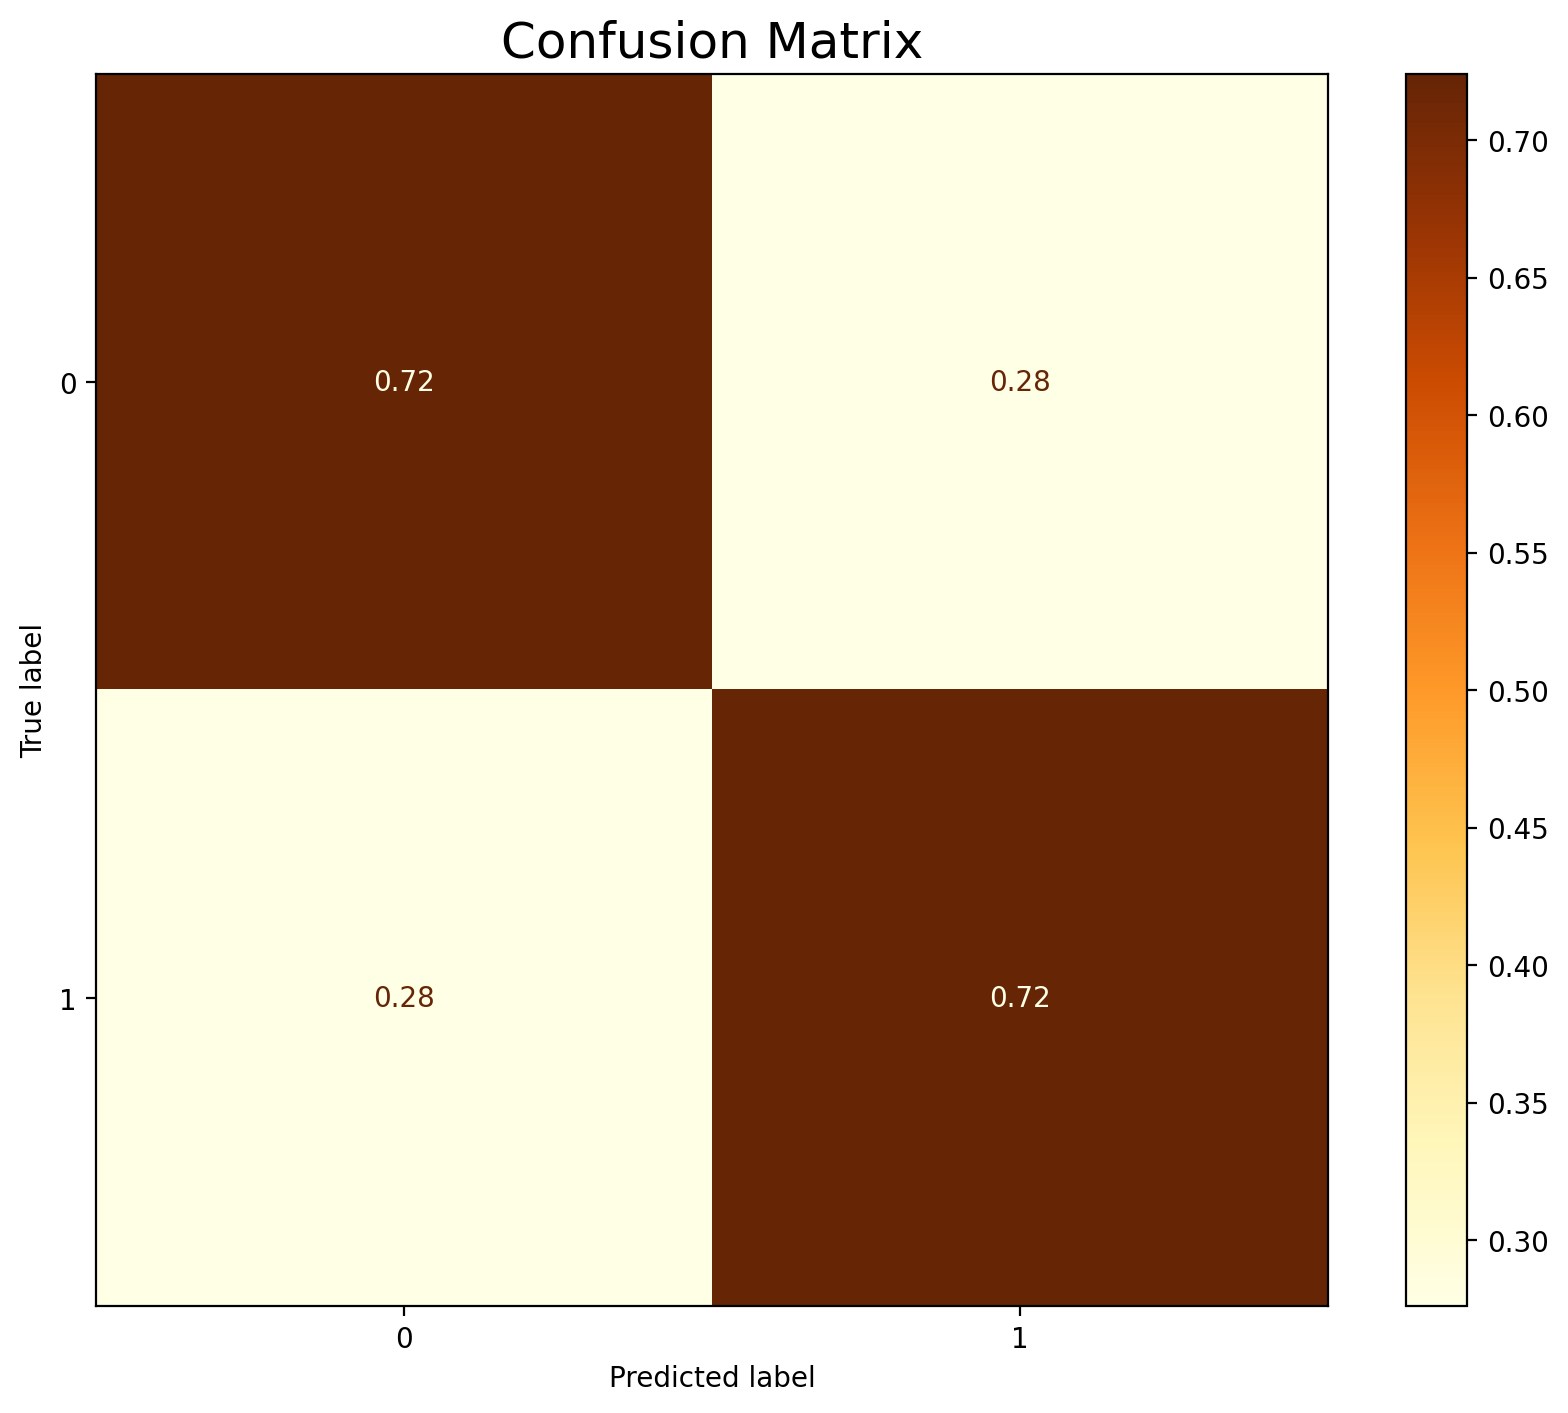

In [5]:
# Resample the data to ensure equal proportions of 'Yes' and 'No' of DM diagnosis
df_mod  = df.dropna(subset=['DM']).copy()
samples = df_mod['DM'].value_counts().min()
df_yes = df_mod[df_mod['DM'] == 'Yes'].sample(samples, replace=False)
df_no = df_mod[df_mod['DM'] == 'No'].sample(samples, replace=False)
df_mod = pd.concat([df_yes, df_no]).sample(frac=1).reset_index(drop=True)

# Dummify the data through a predefined function
df_mod  = dummify(df_mod)

# Create the dataframe and columns needed
y = df_mod['DM']
X = df_mod.drop('DM', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=1212)  

# Create a model pipeline
pipe = make_pipeline(StandardScaler(), PCA(), LogisticRegression())

# Define the hyperparameters to be fine-tuned for the model 
param_grids = {
    'pca__n_components': [0.5, 0.8, 1, 3, 5],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['newton-cg', 'sag']
}

# Hyperparameter tuning using grid search 
# Recall is chosen as the scoring parameter as in our case sensitivity is vital to penalize False Negatives
mod = GridSearchCV(pipe, param_grids, cv=5, scoring=make_scorer(fbeta_score, beta=2, pos_label=1))
mod.fit(X_train, y_train)

# Find the evaluating scores and printing them
params = mod.best_params_
y_preds = mod.predict(X_test)
train_score = round(mod.score(X_train, y_train), 2)
test_score = round(mod.score(X_test, y_test), 2) 
recall = round(recall_score(y_test, y_preds)*100, 2)
precision = round(precision_score(y_test, y_preds)*100, 2)
accuracy = round(accuracy_score(y_test, y_preds)*100, 2)

print(f"""
For this model:
- Best params used to build the model: {params}.
- Train score = {train_score}
- Test score = {test_score}
- Recall = {recall}
- Precision = {precision}
- Accuracy = {accuracy}
""")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f"Confusion Matrix")
plot_confusion_matrix(mod, X_test, y_test, cmap='YlOrBr', normalize='true', ax=ax)
plt.show()